In [ ]:
%matplotlib inline
from scipy.signal import convolve2d
import numpy as np 
import cv2
from matplotlib import pyplot as plt

image = cv2.imread('./cat.jpg')
# 转换为灰度图
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
def show_differences(kernel):
    convolved = convolve2d(image, kernel)
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.title('Original image')
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    
    plt.subplot(122)
    plt.title('Convolved image')
    plt.axis('off')
    plt.imshow(convolved, cmap='gray')
    return convolved

In [ ]:
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9
output = show_differences(kernel)

In [ ]:
kernel = np.ones((8,8), np.float32)/64
dx = show_differences(kernel)

In [ ]:
kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
dx = show_differences(kernel)

In [ ]:
kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
dy = show_differences(kernel)

In [ ]:
mag = np.hypot(dx, dy)  # 欧几里得范数
mag *= 255.0 / np.max(mag)  # 归一化处理

fig = plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('Original image')
plt.axis('off')
plt.imshow(image, cmap='gray')

plt.subplot(122)
plt.title('Convoluted image with highlighted edges')
plt.axis('off')
plt.imshow(mag, cmap='gray')

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import os 
import cv2
from tqdm import tqdm_notebook
from random import shuffle
import shutil
import pandas as pd

In [2]:
def organize_datasets(path_to_data, n=4000, ratio=0.2):
    files = os.listdir(path_to_data)
    files = [os.path.join(path_to_data, f) for f in files]
    shuffle(files)
    files = files[:n]
    
    n = int(len(files) * ratio)
    val, train = files[:n], files[n:]
    

    shutil.rmtree('./data/')
    print('/data/ removed')

    for c in ['dogs', 'cats']: 
        os.makedirs('./data/train/{0}/'.format(c))
        os.makedirs('./data/validation/{0}/'.format(c))

    print('folders created !')

    for t in tqdm_notebook(train):
        if 'cat' in t:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'cats'))
        else:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'dogs'))
     
    for v in tqdm_notebook(val):
        if 'cat' in v:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'cats'))
        else:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'dogs'))
            
    print('Data copied!')

In [3]:
ratio = 0.2
n = 25000
organize_datasets(path_to_data='./train/', n=n, ratio=ratio)

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback

In [5]:
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale=1/255.)

In [7]:
train_generator = train_datagen.flow_from_directory(
        './data/train/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        './data/validation/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [9]:
epochs = 50
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 64)        0         
__________

In [11]:
## 每个epoch的log损失
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

## early stop
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [12]:
from keras import applications
#是否使用全连接层
model = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
generator = datagen.flow_from_directory('./data/train/',
                                        target_size=(150, 150),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

bottleneck_features_train = model.predict_generator(generator, int(n * (1 - ratio)) // batch_size)
np.save(open('./features/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [14]:
generator = datagen.flow_from_directory('./data/validation/',
                                        target_size=(150, 150),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

bottleneck_features_validation = model.predict_generator(generator, int(n * ratio) // batch_size,)
np.save('./features/bottleneck_features_validation.npy', bottleneck_features_validation)

Found 5000 images belonging to 2 classes.


In [15]:
train_data = np.load('./features/bottleneck_features_train.npy')
train_labels = np.array([0] * (int((1-ratio) * n) // 2) + [1] * (int((1 - ratio) * n) // 2))

validation_data = np.load('./features/bottleneck_features_validation.npy')
validation_labels = np.array([0] * (int(ratio * n) // 2) + [1] * (int(ratio * n) // 2))

In [16]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
fitted_model = model.fit(train_data, train_labels,
          epochs=15,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels[:validation_data.shape[0]]),
          verbose=0,
          callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=False), history])

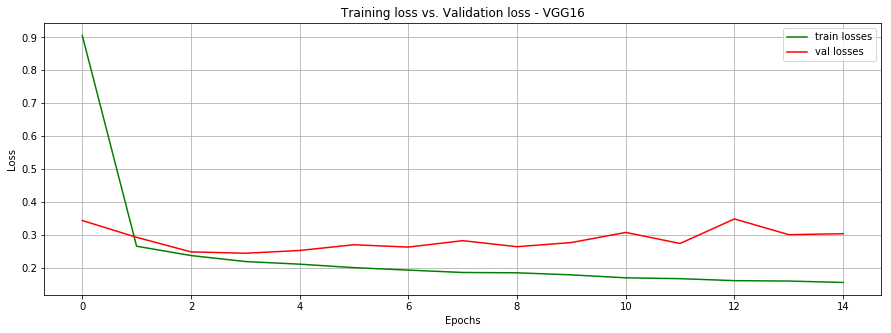

In [18]:
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

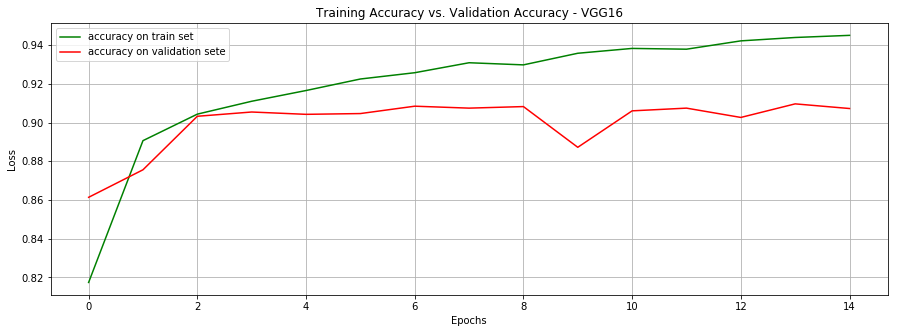

In [19]:
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation sete")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()